In [12]:
import qibo
from qibo.backends import construct_backend
from qibo import hamiltonians
import matplotlib.pyplot as plt
import numpy as np

In [13]:
qibo.set_backend("tensorflow")
vqe_backend = construct_backend(backend="tensorflow")

[Qibo 0.2.12|INFO|2024-12-18 15:31:25]: Using tensorflow backend on /device:CPU:0


[Qibo 0.2.12|WARNING|2024-12-18 15:31:25]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


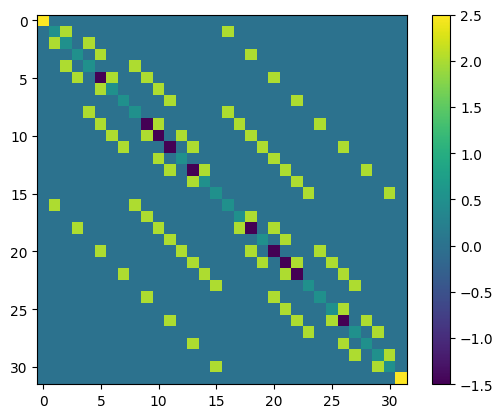

In [14]:
nqubits = 5
delta = 0.5
ham = hamiltonians.XXZ(nqubits, delta, dense=False)
plt.imshow(np.real(ham.matrix))
plt.colorbar()

In [15]:
from boostvqe import ansatze
from copy import deepcopy
from functools import partial
from boostvqe.training_utils import vqe_loss
from boostvqe.utils import *

/Users/pethidine/Library/Caches/pypoetry/virtualenvs/boostvqe-9Q-2T4PW-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
# helper functions
def exact_expectation_boost(ham, circ):
    # calculates the exact expectation of hamiltonian given a circuit in qibo
    return ham.expectation(
        ham.backend.execute_circuit(circuit=circ).state())

In [17]:
# build ansatz circuit
nlayer = 1
ansatz_circ = ansatze.hdw_efficient(nqubits, nlayer)
print(ansatz_circ.draw())

[Qibo 0.2.12|WARNING|2024-12-18 15:31:26]: Starting on qibo 0.2.13, ``Circuit.draw`` will work in-place. The in-place method is currently implemented as ``Circuit.display``, but will be renamed as ``Circuit.draw`` on release 0.2.13. In release 0.2.12, the in-place display of circuits is accessible as ``Circuit.display``.


q0: ─RY─RZ─o───RY─RZ───o─RY─
q1: ─RY─RZ─Z───RY─RZ─o─|─RY─
q2: ─RY─RZ───o─RY─RZ─Z─|─RY─
q3: ─RY─RZ───Z─RY─RZ───|─RY─
q4: ─RY─RZ─────RY─RZ───Z─RY─


In [8]:
# build zero state
zero_state = ham.backend.zero_state(nqubits)
# initial params
params_len = len(ansatz_circ.get_parameters())
# fix numpy seed to ensure replicability of the experiment
seed = 10
np.random.seed(seed)
initial_params = np.random.uniform(-np.pi, np.pi, params_len)
print('Initial parameters:', initial_params)
# initial energy
c0 = deepcopy(ansatz_circ)
c0.set_parameters(initial_params)
target_energy = np.real(np.min(np.asarray(ham.eigenvalues())))
print('Target enegry:', target_energy)
print('Initial energy:', exact_expectation_boost(ham, c0).numpy())
print('Net difference:', exact_expectation_boost(ham, c0).numpy()-target_energy)

Initial parameters: [ 1.70475788 -3.01120431  0.83973663  1.5632809  -0.00938072 -1.72915367
 -1.89712697  1.63696274 -2.07903793 -2.58653723  1.16465009  2.84875441
 -3.11678496  0.07660625  1.96425543  0.70702213  1.39332975 -1.30768123
  2.62495223  1.34821941  0.26731415 -2.2483119  -0.79582348  1.09411377
 -0.36547294]
Target enegry: -6.280513769031045
Initial energy: 1.0802335771641438
Net difference: 7.360747346195189


In [9]:
# define the qibo loss function
objective_boost = partial(vqe_loss)
# logging hisotry
params_history, loss_history, grads_history, fluctuations = [], [], [], []
# set optimizer
optimizer = 'sgd'
maxiter = 1500
nmessage = 500
learning_rate = 5e-2
tol = 1e-5 # for `sgd` this is required but not used
params_history.append(initial_params)

In [10]:
param = params_history[-1]
(
    partial_results,
    partial_params_history,
    partial_loss_history,
    partial_grads_history,
    partial_fluctuations,
    vqe,
) = train_vqe(
    deepcopy(ansatz_circ),
    ham,  # Fixed hamiltonian
    optimizer,
    param,
    tol=tol,
    niterations=maxiter, # Show log info
    nmessage=nmessage,
    loss=objective_boost,
    training_options={'nepochs': maxiter,
                      'learning_rate': learning_rate,}
)
params_history.extend(np.array(partial_params_history))
loss_history.extend(np.array(partial_loss_history))
grads_history.extend(np.array(partial_grads_history))
fluctuations.extend(np.array(partial_fluctuations))

INFO:root:Optimization iteration 0/1500
INFO:root:Loss 1.0802
INFO:root:Minimize the energy
[Qibo 0.2.12|INFO|2024-12-18 11:16:07]: ite 1 : loss 0.826312
INFO:qibo.config:ite 1 : loss 0.826312
INFO:root:Optimization iteration 500/1500
INFO:root:Loss -5.5562
INFO:root:Optimization iteration 1000/1500
INFO:root:Loss -5.6625
[Qibo 0.2.12|INFO|2024-12-18 11:18:42]: ite 1001 : loss -5.662547
INFO:qibo.config:ite 1001 : loss -5.662547
INFO:root:Optimization iteration 1500/1500
INFO:root:Loss -5.6628


In [25]:
import os
folder_path = f'results/vqe_training/{optimizer}_{nqubits}q_{nlayer}l_XXZ'
os.makedirs(folder_path, exist_ok=True)
path_param = folder_path + f'/vqe_params_hist_{nqubits}.npy'
path_loss = folder_path + f'/vqe_loss_hist_{nqubits}.npy'
np.save(path_param, params_history)
np.save(path_loss, loss_history)

NameError: name 'params_history' is not defined

In [7]:
# Training params must be provided if loading directly from file, 
# otherwise comment out the following 2 lines
optimizer = 'sgd'
nlayer = 1
# load from the results/vqe_training folder
import os
folder_path = f'results/vqe_training/{optimizer}_{nqubits}q_{nlayer}l_XXZ/'
os.makedirs(folder_path, exist_ok=True)
path_param = folder_path + f'vqe_params_hist_{nqubits}.npy'
path_loss = folder_path + f'vqe_loss_hist_{nqubits}.npy'

In [18]:
vqe_params = np.load(path_param)
loss_history = np.load(path_loss)
vqe_param_final = vqe_params[-1]
ansatz_circ.set_parameters(vqe_param_final)
vqe_circ = ansatz_circ

In [19]:
print(vqe_circ.draw())

[Qibo 0.2.12|WARNING|2024-12-18 15:31:31]: Starting on qibo 0.2.13, ``Circuit.draw`` will work in-place. The in-place method is currently implemented as ``Circuit.display``, but will be renamed as ``Circuit.draw`` on release 0.2.13. In release 0.2.12, the in-place display of circuits is accessible as ``Circuit.display``.


q0: ─RY─RZ─o───RY─RZ───o─RY─
q1: ─RY─RZ─Z───RY─RZ─o─|─RY─
q2: ─RY─RZ───o─RY─RZ─Z─|─RY─
q3: ─RY─RZ───Z─RY─RZ───|─RY─
q4: ─RY─RZ─────RY─RZ───Z─RY─


In [24]:
c = Circuit(10)
c.add(vqe_circ.on_qubits(*range(0,5)))
c.add(vqe_circ.on_qubits(*range(5,10)))
print(c.draw())

[Qibo 0.2.12|WARNING|2024-12-18 15:32:00]: Starting on qibo 0.2.13, ``Circuit.draw`` will work in-place. The in-place method is currently implemented as ``Circuit.display``, but will be renamed as ``Circuit.draw`` on release 0.2.13. In release 0.2.12, the in-place display of circuits is accessible as ``Circuit.display``.


q0: ─RY─RZ─o───RY─RZ───o─RY─────────────────────
q1: ─RY─RZ─Z───RY─RZ─o─|─RY─────────────────────
q2: ─RY─RZ───o─RY─RZ─Z─|─RY─────────────────────
q3: ─RY─RZ───Z─RY─RZ───|─RY─────────────────────
q4: ─RY─RZ─────RY─RZ───Z─RY─────────────────────
q5: ─────────────────────RY─RZ─o───RY─RZ───o─RY─
q6: ─────────────────────RY─RZ─Z───RY─RZ─o─|─RY─
q7: ─────────────────────RY─RZ───o─RY─RZ─Z─|─RY─
q8: ─────────────────────RY─RZ───Z─RY─RZ───|─RY─
q9: ─────────────────────RY─RZ─────RY─RZ───Z─RY─


In [27]:
nqubits = 2 * nqubits

In [35]:
full_ham = hamiltonians.XXZ(nqubits, delta, dense=False)
print(exact_expectation_boost(full_ham, c))

tf.Tensor(-6.326365159973651, shape=(), dtype=float64)


In [28]:
# steps (int): Number of time steps (default 1).
# order (int): the order of product formula, as of now, it takes value 1 or 2.
base_oracle = XXZ_EvolutionOracle.from_nqubits(
    nqubits=nqubits, delta=0.5, steps=1, order=1
)
# the following circuit performs exp{-0.01iH}
base_circ = base_oracle.circuit(t_duration=0.01)
print(base_circ.draw())

[Qibo 0.2.12|WARNING|2024-12-19 10:35:18]: Starting on qibo 0.2.13, ``Circuit.draw`` will work in-place. The in-place method is currently implemented as ``Circuit.display``, but will be renamed as ``Circuit.draw`` on release 0.2.13. In release 0.2.12, the in-place display of circuits is accessible as ``Circuit.display``.


q0:     ────X─────────RZ─o────────────X─────────RZ─RZ─────────o─RY─────────X─R ...
q1:     ─RZ─o─────────RY─X─────────RY─o───────────────X───────|─RZ─o───────|── ...
q2:     ──────X───────RZ───o────────────X───────RZ─RZ─o───────|─RY─X───────|─R ...
q3:     ─RZ───o───────RY───X───────RY───o───────────────X─────|─RZ───o─────|── ...
q4:     ────────X─────RZ─────o────────────X─────RZ─RZ───o─────|─RY───X─────|─R ...
q5:     ─RZ─────o─────RY─────X─────RY─────o───────────────X───|─RZ─────o───|── ...
q6:     ──────────X───RZ───────o────────────X───RZ─RZ─────o───|─RY─────X───|─R ...
q7:     ─RZ───────o───RY───────X───RY───────o───────────────X─|─RZ───────o─|── ...
q8:     ────────────X─RZ─────────o────────────X─RZ─RZ───────o─|─RY───────X─|─R ...
q9:     ─RZ─────────o─RY─────────X─RY─────────o───────────────X─RZ─────────o── ...

q0: ... Y─────────o────
q1: ... ──X───────|─RZ─
q2: ... Y─o───────|────
q3: ... ────X─────|─RZ─
q4: ... Y───o─────|────
q5: ... ──────X───|─RZ─
q6: ... Y─────o───|────
q

In [29]:
frame_oracle = FrameShiftedEvolutionOracle.from_evolution_oracle(
    circuit_frame=c,
    base_evolution_oracle=base_oracle,
)

In [30]:
# db_rotation = DoubleBracketRotationType.group_commutator_third_order_reduced
dbr_type = DoubleBracketRotationType.group_commutator_reduced
gci = GroupCommutatorIterationWithEvolutionOracles(
        frame_oracle,
        dbr_type
    )

In [31]:
eo_d_type = MagneticFieldEvolutionOracle
print(
        f"The gci mode is {gci.mode} rotation with {eo_d_type.__name__} as the oracle.\n"
    )

The gci mode is DoubleBracketRotationType.group_commutator_reduced rotation with MagneticFieldEvolutionOracle as the oracle.



In [32]:
# GCI settings
steps = 1
optimization_method = "sgd"
gd_epochs = 20
opt_options = {'gd_epochs':gd_epochs, }

In [36]:
for gci_step_nmb in range(steps):
    logging.info(
        "\n################################################################################\n"
        + f"Optimizing GCI step {gci_step_nmb+1} with optimizer {optimization_method}"
        + "\n################################################################################\n"
    )
    it = time.time()
    if optimization_method == optimization_method:
        params = (
            [4 - np.sin(x / 3) for x in range(nqubits)]
            if eo_d_type == MagneticFieldEvolutionOracle
            else [4 - np.sin(x / 3) for x in range(nqubits)] + nqubits * [1]
        )
        mode, best_s, best_b, eo_d = select_recursion_step_gd_circuit(
            gci,
            mode=dbr_type,
            eo_d_type=eo_d_type,
            params=params,
            step_grid=np.linspace(1e-5, 2e-2, 30),
            lr_range=(1e-3, 1),
            nmb_gd_epochs=gd_epochs,
            threshold=1e-4,
            max_eval_gd=30,
        )

        opt_dict = {"sgd_extras": "To be defined"}

    else:
        if gci_step_nmb == 0:
            p0 = [0.01]
            if eo_d_type == MagneticFieldEvolutionOracle:
                p0.extend([4 - np.sin(x / 3) for x in range(nqubits)])
            elif eo_d_type == IsingNNEvolutionOracle:
                p0.extend(
                    [4 - np.sin(x / 3) for x in range(nqubits)] + nqubits * [1]
                )

        else:
            p0 = [best_s]
            p0.extend(best_b)
        optimized_params, opt_dict = optimize_D(
            params=p0,
            gci=gci,
            eo_d_type=eo_d_type,
            mode=dbr_type,
            method=optimization_method,
            **opt_options,
        )
        best_s = optimized_params[0]
        best_b = optimized_params[1:]
        eo_d = eo_d_type.load(best_b)

    step_data = dict(
        best_s=best_s,
        eo_d_name=eo_d.__class__.__name__,
        eo_d_params=eo_d.params,
    )
    logging.info(f"Total optimization time required: {time.time() - it} seconds")
    gci.mode_double_bracket_rotation = dbr_type

    gci(best_s, eo_d, dbr_type)


INFO:root:
################################################################################
Optimizing GCI step 1 with optimizer sgd
################################################################################

INFO:root:Total optimization time required: 117.32290601730347 seconds


Just finished the selection: better loss -9.386511193143779 for mode DoubleBracketRotationType.group_commutator_reduced,                with duration s=0.0249975, and eo_d name = MagneticFieldEvolutionOracle


In [37]:
from qibo.quantum_info.metrics import fidelity

In [38]:
def report(vqe_circ, hamiltonian, gci, step, eo_d, mode):
    energies = hamiltonian.eigenvalues()
    ground_state_energy = float(energies[0])
    vqe_energy = float(hamiltonian.expectation(vqe_circ().state()))
    gci_loss = float(gci.loss(step, eo_d, mode))
    gap = float(energies[1] - energies[0])

    return (
        dict(
            nqubits=hamiltonian.nqubits,
            gci_loss=float(gci_loss),
            vqe_energy=float(vqe_energy),
            target_energy=ground_state_energy,
            diff_vqe_target=vqe_energy - ground_state_energy,
            diff_gci_target=gci_loss - ground_state_energy,
            gap=gap,
            diff_vqe_target_perc=abs(vqe_energy - ground_state_energy)
            / abs(ground_state_energy)
            * 100,
            diff_gci_target_perc=abs(gci_loss - ground_state_energy)
            / abs(ground_state_energy)
            * 100,
            fidelity_witness_vqe=1 - (vqe_energy - ground_state_energy) / gap,
            fidelity_witness_gci=1 - (gci_loss - ground_state_energy) / gap,
            fidelity_vqe=fidelity(vqe_circ().state(), hamiltonian.ground_state()),
            fidelity_gci=fidelity(
                gci.get_composed_circuit(best_s, eo_d, dbr_type)().state(), hamiltonian.ground_state()
            ),
        )
        | gci.get_gate_count_dict(gci.get_composed_circuit(best_s, eo_d, dbr_type))
    )
    
def print_report(report: dict):
    print(
        f"\
    The target energy is {report['target_energy']}\n\
    The VQE energy is {report['vqe_energy']} \n\
    The DBQA energy is {report['gci_loss']}. \n\
    The difference is for VQE is {report['diff_vqe_target']} \n\
    and for the DBQA {report['diff_gci_target']} \n\
    which can be compared to the spectral gap {report['gap']}.\n\
    The relative difference is \n\
        - for VQE {report['diff_vqe_target_perc']}% \n\
        - for DBQA {report['diff_gci_target_perc']}%.\n\
    The energetic fidelity witness of the ground state is: \n\
        - for the VQE  {report['fidelity_witness_vqe']} \n\
        - for DBQA {report['fidelity_witness_gci']}\n\
    The true fidelity is \n\
        - for the VQE  {report['fidelity_vqe']}\n\
        - for DBQA {report['fidelity_gci']}\n\
                    "
    )
    print(
        f"The boosting circuit used {report['nmb_cnot']} CNOT gates coming from compiled XXZ evolution and {report['nmb_cz']} CZ gates from VQE.\n\
For {report['nqubits']} qubits this gives n_CNOT/n_qubits = {report['nmb_cnot_relative']} and n_CZ/n_qubits = {report['nmb_cz_relative']}"
    )

In [40]:
this_report = report(c, full_ham, gci, best_s, eo_d, dbr_type)
print_report(this_report)

[Qibo 0.2.12|WARNING|2024-12-19 10:42:42]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
/Users/pethidine/Library/Caches/pypoetry/virtualenvs/boostvqe-9Q-2T4PW-py3.11/lib/python3.11/site-packages/tensorflow/python/framework/ops.py:307: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


    The target energy is -15.276131122065879
    The VQE energy is -6.326365159973651 
    The DBQA energy is -10.9765663855174. 
    The difference is for VQE is 8.949765962092227 
    and for the DBQA 4.299564736548479 
    which can be compared to the spectral gap 1.0876654489811521.
    The relative difference is 
        - for VQE 58.58660082568014% 
        - for DBQA 28.14563911629363%.
    The energetic fidelity witness of the ground state is: 
        - for the VQE  -7.228418003417994 
        - for DBQA -2.953021345466114
    The true fidelity is 
        - for the VQE  1.0309977637696196e-34
        - for DBQA 2.156121280482839e-05
                    
The boosting circuit used 120 CNOT gates coming from compiled XXZ evolution and 72 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 7.2 and n_CZ/n_qubits = 12.0


In [41]:
composed_circ = gci.get_composed_circuit(best_s, eo_d, dbr_type)

In [42]:
vqe_c = models.Circuit.to_qasm(c)
gci_c = models.Circuit.to_qasm(composed_circ)

In [43]:
folder_path = f'results/circuit_qasm/{optimizer}_{nqubits}q_{nlayer}l_XXZ/'
os.makedirs(folder_path, exist_ok=True)
with open(folder_path + f"vqe_circ_step1_2vqe.qasm", "w") as file:
    file.write(vqe_c)

with open(folder_path + f"gci_circ_step1_2vqe.qasm", "w") as file:
    file.write(gci_c)